# Explorativní analýza a statistika jedné proměnné

V této lekci se podíváme na základní nástroje a postupy, které se hodí pro analýzu jedné proměnné. Nebudeme se tedy zabývat vztahy a souvislostmi mezi více proměnnými - to bude předmětem mnohých dalších lekcí. Na pomoc si pro tento účel vezmeme především časové řady s údaji o počasí (teplota, tlak apod.). V práci nám bude významě pomáhat vizualizace.

Abychom s daty mohli efektivně pracovat, budeme muset data ještě pročistit. To je (bohužel) běžnou součástí datové analýzy, protože zdrojová data často obsahují chyby. Při práci s časovými řadami využijeme bohaté možnosti `pandas` pro práci s časovými údaji.

Podíváme se na základy statistiky. Dozvíme se, jak pracovat s pojmy střední hodnota, standardní odchylka, medián, kvantil či kvartil. Naučíme se pracovat s histogramy, s boxploty a s distribuční funkcí.

V této lekci se naučíš:
* načítat data ze souborů ve formátu Excel,
* efektivně čistit data,
* základní statistiky jedné proměnné, včetně rozdělovací funkce,
* vizualizovat časové řady a jejich statistické vlastnosti.

## Načtení knihoven

Budeme používat samozřejmě `pandas`, pro vizualizaci pak [`matplotlib`](https://matplotlib.org/) a [`seaborn`](https://seaborn.pydata.org/).

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Příprava dat

### Načtení dat o počasí

Naší základní datovou sadou budou data o počasí v České Republice. Data na svých stránkách poskytuje hydrometeorologický ústav (ČHMÚ): https://www.chmi.cz/historicka-data/pocasi/denni-data. 

Možná překvapivě není úplně snadné dobrá a podrobná data získat. Naštěstí ale existuje služba [meteostat](https://meteostat.net/en/) a stejnojmenná knihovna pro Python, kterou jsme použili pro stažení dat pro několik českých stanic. Notebook [weather_data.ipynb](weather_data.ipynb) obsahuje kód pro to použitý, ale nebudeme se jím zde zabývat.

Samotné načtení souboru je poměrně snadné. Použijeme na to třídu `ExcelFile`, protože kromě načítání poskytuje také property `sheet_names`.

Často stačí (a je jednodušší) použít funkci [`read_excel`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_excel.html#pandas.read_excel). V dokumentaci si všimni velkého množství argumentů, které umožňují správně načíst všelijak formátované soubory a hodnoty v nich. 

In [ ]:
DATA_FILENAME = "data-daily.xlsx"

# otevření Excel souboru
denni_excel = pd.ExcelFile(DATA_FILENAME)
denni_excel

Zobrazíme si seznam listů v souboru.

In [ ]:
denni_excel.sheet_names

['Praha-Ruzyne', 'Plzen-Line', 'Karlovy Vary', 'Brno-Turany', 'Holesov']

Zatím jsme žádná data nenačetli (nemáme žádný `DataFrame` s daty ze souboru). Data načte ve formě `DataFrame` až metoda [`parse`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.ExcelFile.parse.html#pandas.ExcelFile.parse).

In [30]:
# načti data z jednoho listu
denni_ruzyne_original = denni_excel.parse("Praha-Ruzyne")
denni_ruzyne_original

,time,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
0,1940-01-02,-9.4,NaN,-7.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1940-01-03,-9.9,-13.9,-6.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1940-01-06,-7.0,-7.8,-6.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1940-01-07,-9.2,-11.1,-7.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1940-01-12,-15.9,-22.8,-11.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
23272,2025-08-27,18.8,12.6,27.0,0.3,NaN,NaN,9.7,24.1,1012.1,429.0
23273,2025-08-28,21.2,15.7,30.0,7.0,NaN,NaN,12.0,47.0,1006.3,374.0
23274,2025-08-29,18.6,15.3,23.7,17.7,NaN,NaN,10.4,27.8,1004.4,231.0
23275,2025-08-30,18.1,15.2,23.0,13.1,NaN,NaN,12.2,33.3,1008.3,292.0


In [31]:
denni_ruzyne_original.dtypes

time    datetime64[ns]
tavg           float64
tmin           float64
tmax           float64
prcp           float64
snow           float64
wdir           float64
wspd           float64
wpgt           float64
pres           float64
tsun           float64
dtype: object

Pro vysvětelnou dodejme, co který sloupec znamená (viz https://dev.meteostat.net/formats.html#meteorological-parameters):
- `time`: čas (nebo spíš datum) měření
- `tavg`: průměrná denní teplota (°C)
- `tmin`: nejnižší denní teplota (°C)
- `tmax`: nejvyšší denní teplota (°C)
- `prcp`: celkový úhrn srážek (mm)
- `snow`: výška sněhové pokrývky (mm)
- `wdir`: směr větru (°)
- `wspd`: rychlost větru (km/h)
- `wpgt`: max. rychlost větru v poryvech (km/h)
- `pres`: tlak  (hPa)
- `tsun`: doba slunečního svitu (min)

### Časový index

Protože se budeme zabývat časovými řadami, je zcela přirozené, že ze sloupce "time" uděláme index:

In [32]:
denni_ruzyne_index = denni_ruzyne_original.set_index("time")
denni_ruzyne_index

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
time,,,,,,,,,,
1940-01-02,-9.4,NaN,-7.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1940-01-03,-9.9,-13.9,-6.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1940-01-06,-7.0,-7.8,-6.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1940-01-07,-9.2,-11.1,-7.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1940-01-12,-15.9,-22.8,-11.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2025-08-27,18.8,12.6,27.0,0.3,NaN,NaN,9.7,24.1,1012.1,429.0
2025-08-28,21.2,15.7,30.0,7.0,NaN,NaN,12.0,47.0,1006.3,374.0
2025-08-29,18.6,15.3,23.7,17.7,NaN,NaN,10.4,27.8,1004.4,231.0


### Čištění dat

Vidíme, že mnoho sloupců obsahuje "NaN", neboli "not a number" - to může znamenat ledacos.

⚠️ Poznámka: NaN je původně numerickou reprezentací **neplatné matematické operace** (jako např. 0 / 0), nicméně v pandas se tento význam směšuje s **chybějící hodnotou** (missign value, N/A). Je to podobné, ale ne totéž. Naopak některé jiné knihovny (např. polars) mezi oběma významy rigorózně rozlišují, což může být zdrojem nepěkných chyb, když mezi knihovnami člověk přechází.

Pojďme se podívat, jak chybějící/neplatné hodnoty odhalit a co se s nimi dá dělat.

Obecně máme tři základní možnosti.

1. Nedělat nic, tj. nechat chybějící data chybět. To je možná překvapivě často dobrá volba, protože mnoho funkcí si s chybějícími daty poradí správně. To je rozdíl oproti `numpy`, kde funkce typicky `NaN`y nemají rády. Často existují varianty funkcí (např. `numpy.mean` -> `numpy.nanmean`), které `NaN`y berou jako chybějící data. 

2. Pozorování (tj. řádky, protože máme tidy data) s chybějícími záznamy vynechat. K tomu slouží metoda [`dropna`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html#pandas.DataFrame.dropna).

3. Chybějící data nahradit nějakou vhodnou hodnotou. Co jsou vhodné hodnoty, záleží na povaze dat a na tom, co s daty dále děláme. Někdy je vhodné nahradit chybějící hodnoty nějakou "typickou" hodnotou, třeba průměrem. Pro časové řady je většinou logičtější nahradit hodnotou z okolí (předchozí nebo následující). O nahrazování typickými hodnotami (angl. imputation) se dočteš https://scikit-learn.org/stable/modules/impute.html a možná dozvíš víc i později. K nahrazování hodnotami z okolí pak slouží metoda [`fillna`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html#pandas.DataFrame.fillna).


Nejprve bychom ale měli zjistit, kde přesně ty chybějící hodnoty jsou. Metoda [`isna`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.isna.html#pandas.DataFrame.isna) nám dokáže "najít" nedefinované hodnoty:

In [33]:
denni_ruzyne_index.isna()

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
time,,,,,,,,,,
1940-01-02,False,True,False,True,True,True,True,True,True,True
1940-01-03,False,False,False,True,True,True,True,True,True,True
1940-01-06,False,False,False,True,True,True,True,True,True,True
1940-01-07,False,False,False,True,True,True,True,True,True,True
1940-01-12,False,False,False,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...
2025-08-27,False,False,False,False,True,True,False,False,False,False
2025-08-28,False,False,False,False,True,True,False,False,False,False
2025-08-29,False,False,False,False,True,True,False,False,False,False


Použití `sum` na `True` a `False` je užitečný trik, `True` se počítá jako 1, `False` jako 0.

In [34]:
denni_ruzyne_index.isna().sum()

tavg       19
tmin     2682
tmax      508
prcp     8634
snow    22226
wdir    23277
wspd     6262
wpgt    20689
pres    12109
tsun    22159
dtype: int64

Vidíme tedy, že ve sloupcích s průměrnou teplotou je 19 nedefinovaných hodnot, zatímco pro sloupec `wdir` jsou všechny hodnoty NaN (koncept průměrného denního směru větru patrně nedává úplně smysl).

Opak nám ukaže metoda [`.count`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.count.html):

In [42]:
denni_ruzyne_index.count()

tavg    23258
tmin    20595
tmax    22769
prcp    14643
snow     1051
wdir        0
wspd    17015
wpgt     2588
pres    11168
tsun     1118
dtype: int64

**Otázka:** Co vrátí `denni_ruzyne.isna().count()`?

Sloupec `wdir` patrně můžeme vyhodit, protože neobsahuje žádnou užitečnou informaci. Na to stačí [`.drop`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.count.html):

In [35]:
denni_ruzyne_bez_wdir = denni_ruzyne_index.drop(columns="wdir")
denni_ruzyne_bez_wdir

,tavg,tmin,tmax,prcp,snow,wspd,wpgt,pres,tsun
time,,,,,,,,,
1940-01-02,-9.4,NaN,-7.2,NaN,NaN,NaN,NaN,NaN,NaN
1940-01-03,-9.9,-13.9,-6.1,NaN,NaN,NaN,NaN,NaN,NaN
1940-01-06,-7.0,-7.8,-6.1,NaN,NaN,NaN,NaN,NaN,NaN
1940-01-07,-9.2,-11.1,-7.2,NaN,NaN,NaN,NaN,NaN,NaN
1940-01-12,-15.9,-22.8,-11.1,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2025-08-27,18.8,12.6,27.0,0.3,NaN,9.7,24.1,1012.1,429.0
2025-08-28,21.2,15.7,30.0,7.0,NaN,12.0,47.0,1006.3,374.0
2025-08-29,18.6,15.3,23.7,17.7,NaN,10.4,27.8,1004.4,231.0


A co s onou teplotou?

In [39]:
denni_ruzyne_bez_wdir.loc[denni_ruzyne_bez_wdir["tavg"].isna()]

,tavg,tmin,tmax,prcp,snow,wspd,wpgt,pres,tsun
time,,,,,,,,,
1973-01-04,NaN,NaN,NaN,NaN,NaN,11.1,NaN,NaN,NaN
1975-02-13,NaN,NaN,NaN,NaN,NaN,5.5,NaN,NaN,NaN
1975-02-21,NaN,NaN,NaN,NaN,NaN,2.4,NaN,NaN,NaN
1975-10-28,NaN,NaN,NaN,NaN,NaN,1.7,NaN,NaN,NaN
1975-12-15,NaN,NaN,NaN,NaN,NaN,5.9,NaN,NaN,NaN
1976-12-20,NaN,NaN,NaN,NaN,NaN,7.5,NaN,NaN,NaN
1977-02-14,NaN,NaN,NaN,NaN,NaN,7.1,NaN,NaN,NaN
1978-02-27,NaN,NaN,NaN,NaN,NaN,10.2,NaN,NaN,NaN
1987-12-31,NaN,NaN,NaN,NaN,NaN,6.7,NaN,NaN,NaN


Oněch 19 řádků odpovídá patrně dnům, kdy meteostanice "neměla" svůj den. Tyto řádky má asi smysl úplně **odstranit**. Na to použijeme metodu `.dropna`, jen budeme muset specifikovat, který sloupec nám vadí:

In [49]:
denni_ruzyne = denni_ruzyne_bez_wdir.dropna(subset=["tavg"])
denni_ruzyne

,tavg,tmin,tmax,prcp,snow,wspd,wpgt,pres,tsun
time,,,,,,,,,
1940-01-02,-9.4,NaN,-7.2,NaN,NaN,NaN,NaN,NaN,NaN
1940-01-03,-9.9,-13.9,-6.1,NaN,NaN,NaN,NaN,NaN,NaN
1940-01-06,-7.0,-7.8,-6.1,NaN,NaN,NaN,NaN,NaN,NaN
1940-01-07,-9.2,-11.1,-7.2,NaN,NaN,NaN,NaN,NaN,NaN
1940-01-12,-15.9,-22.8,-11.1,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2025-08-27,18.8,12.6,27.0,0.3,NaN,9.7,24.1,1012.1,429.0
2025-08-28,21.2,15.7,30.0,7.0,NaN,12.0,47.0,1006.3,374.0
2025-08-29,18.6,15.3,23.7,17.7,NaN,10.4,27.8,1004.4,231.0


Mohli bychom zkusit odstranit všechny řádky, kde něco chybí:

In [50]:
denni_ruzyne.dropna()

,tavg,tmin,tmax,prcp,snow,wspd,wpgt,pres,tsun
time,,,,,,,,,
2022-12-02,-0.6,-1.3,0.2,0.0,1.0,14.6,29.6,1023.9,1.0
2022-12-09,-0.8,-3.2,0.2,0.0,1.0,9.3,20.4,1007.4,98.0
2022-12-15,-6.4,-9.2,-2.3,2.5,7.0,8.0,22.2,1010.1,148.0
2022-12-17,-4.3,-9.1,-1.3,0.8,11.0,10.2,25.9,1026.3,75.0
2022-12-22,5.3,0.6,8.3,4.1,4.0,19.0,47.0,1009.9,17.0
2023-01-18,0.5,-1.9,2.9,0.5,1.0,12.0,24.1,993.8,20.0
2023-01-20,-1.7,-3.4,-0.5,0.0,1.0,10.2,33.3,1016.0,40.0
2023-01-23,-0.7,-2.7,0.6,1.5,5.0,9.8,25.9,1034.8,26.0
2023-01-24,0.0,-0.3,0.5,0.0,4.0,9.9,22.2,1037.6,2.0


Popravdě, zbylo by nám jen nějakých 34 řádků, v zimním období, a všechny jsou novější než rok 2022. Proč tomu tak je? Svou roli zde hraje několik faktorů dohromady, které nepůjde snadno rozklíčovat bez vizualizace. A bohužel tedy ani nevím, jak bychom správně aplikovali `fillna`.

**Úkol:** Zkuste odstranit všechny řádky, pro které není definován `tsun`. Co nám to říká?

**Úkol:** Zkuste odstranit všechny řádky, pro které není definován `snow`. Co nám to říká?

## Indexování a výběr intervalů

Data, která jsme načetli a vyčistili, tvoří vlastně několik časových řad v jednotlivých sloupcích tabulky `ruzyne_tidy`. Granularita (nebo frekvence či časové rozlišení) je jeden den.

Pomocí `to_period()` bychom mohli datový typ indexu převést i na `period[D]`. To může zrychlit některé operace, pro naše použití to ale není nezbytné.

In [51]:
denni_ruzyne.index.to_period("D")

PeriodIndex(['1940-01-02', '1940-01-03', '1940-01-06', '1940-01-07',
             '1940-01-12', '1940-01-13', '1940-01-14', '1940-01-18',
             '1940-01-19', '1940-01-21',
             ...
             '2025-08-22', '2025-08-23', '2025-08-24', '2025-08-25',
             '2025-08-26', '2025-08-27', '2025-08-28', '2025-08-29',
             '2025-08-30', '2025-08-31'],
            dtype='period[D]', name='time', length=23258)

Už jsme si ukazovali indexování (výběr intervalu) pomocí `.loc`. U časových řad to funguje samozřejmě také. Pozor na to, že `.loc` vrací data *včetně* horní meze, *na rozdíl* od indexování `list`ů nebo numpy polí. 

Konkrétní období můžeme vybrat třeba takto:

In [52]:
denni_ruzyne.loc[pd.Timestamp(2017, 12, 24) : pd.Timestamp(2018, 1, 1)]


,tavg,tmin,tmax,prcp,snow,wspd,wpgt,pres,tsun
time,,,,,,,,,
2017-12-24,6.2,5.5,7.0,NaN,NaN,28.8,NaN,1024.2,NaN
2017-12-25,3.1,-0.9,5.5,NaN,NaN,18.2,NaN,1021.0,NaN
2017-12-26,0.1,-4.0,4.2,NaN,NaN,11.2,NaN,1010.1,NaN
2017-12-27,-0.3,-2.7,2.1,NaN,NaN,11.0,NaN,995.5,NaN
2017-12-28,0.6,-0.4,1.5,NaN,NaN,14.6,NaN,994.4,NaN
2017-12-29,-1.4,-3.5,0.5,NaN,NaN,19.8,NaN,1009.7,NaN
2017-12-30,0.6,-3.2,5.0,NaN,NaN,17.7,NaN,1007.5,NaN
2017-12-31,8.5,5.7,11.1,NaN,NaN,26.0,NaN,1007.6,NaN
2018-01-01,5.3,0.7,7.5,NaN,NaN,17.1,NaN,1006.8,NaN


Anebo dokonce i takto zjednodušeně:

In [53]:
denni_ruzyne.loc["2017":"2019"]

,tavg,tmin,tmax,prcp,snow,wspd,wpgt,pres,tsun
time,,,,,,,,,
2017-01-01,-6.2,-8.7,-2.2,NaN,NaN,4.8,NaN,1024.0,NaN
2017-01-02,-2.7,-8.7,-0.9,NaN,NaN,20.4,NaN,1018.7,NaN
2017-01-03,-1.2,-4.7,0.6,NaN,NaN,29.4,NaN,1020.7,NaN
2017-01-04,0.2,-1.5,2.0,NaN,NaN,39.3,NaN,1006.6,NaN
2017-01-05,-4.6,-9.0,-1.2,NaN,NaN,21.9,NaN,1023.2,NaN
...,...,...,...,...,...,...,...,...,...
2019-12-27,1.7,1.0,3.2,0.1,NaN,11.2,25.9,1028.2,NaN
2019-12-28,-0.4,-1.0,1.0,0.3,NaN,16.3,33.3,1040.1,NaN
2019-12-29,-1.5,-3.5,0.7,0.0,NaN,7.7,18.5,1041.4,NaN


### Atributy časových proměnných

Časové proměnné typu [`DatetimeIndex`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DatetimeIndex.html) poskytují velice užitečnou sadu atributů vracející
* části časového údaje, např. `.year` vrátí pouze rok, `.month` měsíc apod., 
* relativní informace , např. `.weekday` nebo `.weekofyear`
* kalendářní vlastnosti jako `is_quarter_start` nebo `is_year_end`, které by bylo poměrně náročné zjišťovat numericky.

Pokud se jedná o sloupec, je potřeba před atribut vložit ještě [`.dt`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.dt.html) accessor. 

In [54]:
denni_ruzyne.index.year

Index([1940, 1940, 1940, 1940, 1940, 1940, 1940, 1940, 1940, 1940,
       ...
       2025, 2025, 2025, 2025, 2025, 2025, 2025, 2025, 2025, 2025],
      dtype='int32', name='time', length=23258)

Můžeme tak vybrat jeden celý rok např. takto:

In [55]:
denni_ruzyne.loc[denni_ruzyne.index.year == 2018]

,tavg,tmin,tmax,prcp,snow,wspd,wpgt,pres,tsun
time,,,,,,,,,
2018-01-01,5.3,0.7,7.5,NaN,NaN,17.1,NaN,1006.8,NaN
2018-01-02,3.8,1.5,5.2,NaN,NaN,23.4,NaN,1009.0,NaN
2018-01-03,3.4,0.5,7.6,1.0,NaN,26.0,NaN,999.2,NaN
2018-01-04,4.9,4.2,5.6,NaN,NaN,25.2,NaN,999.6,NaN
2018-01-05,6.9,4.7,9.0,NaN,NaN,19.8,NaN,1000.7,NaN
...,...,...,...,...,...,...,...,...,...
2018-12-27,4.0,3.0,6.2,0.0,NaN,19.5,31.5,1026.8,NaN
2018-12-28,3.5,0.6,5.6,0.0,NaN,15.3,27.8,1026.1,NaN
2018-12-29,2.6,1.0,4.0,0.1,NaN,19.5,40.8,1028.9,NaN


Nebo můžeme získat data pro všechny dny před rokem 1989, které jsou začátky kvartálů a zároveň to jsou pondělky.

In [56]:
denni_ruzyne.loc[
    denni_ruzyne.index.is_quarter_start
    & (denni_ruzyne.index.weekday == 0)
    & (denni_ruzyne.index.year < 1989)
]

,tavg,tmin,tmax,prcp,snow,wspd,wpgt,pres,tsun
time,,,,,,,,,
1940-04-01,6.8,1.1,12.8,NaN,NaN,NaN,NaN,NaN,NaN
1957-04-01,5.6,3.9,8.9,3.0,NaN,NaN,NaN,NaN,NaN
1962-01-01,0.3,-3.9,2.2,NaN,NaN,NaN,NaN,NaN,NaN
1962-10-01,14.9,7.8,22.2,NaN,NaN,NaN,NaN,NaN,NaN
1963-04-01,1.2,NaN,2.2,1.5,NaN,NaN,NaN,NaN,NaN
1963-07-01,17.6,15.0,21.1,12.7,NaN,NaN,NaN,NaN,NaN
1973-01-01,-2.6,NaN,NaN,NaN,NaN,12.2,NaN,NaN,NaN
1973-10-01,9.6,6.0,13.0,0.0,NaN,3.0,NaN,NaN,NaN
1974-04-01,10.4,5.0,16.0,0.0,NaN,8.6,NaN,NaN,NaN


**Úkol:** Nejstarší tag Pandas na https://github.com/pandas-dev/pandas je verze 0.3.0 z 20. února 2011. Jaké bylo v ten den v Praze - Ruzyni počasi?

**Úkol:** Jaká byla průměrná teplota první (a jedinou) neděli v roce 2010, která byla zároveň začátkem měsíce? Pokud máte řešení a čas, zkuste vymyslet aternativní způsob(y). 

In [ ]:
# odkomentuj a doplň
# denni_ruzyne.loc[
#     ___
#     & (___)
#     & (___),
#     "teplota průměrná",
# ]

## Základní vizualizace a statistika

Vykreslíme si naše data co nejjednoduššími způsoby, jaké nám pandy nabízí. Zkusme třeba rovnou `.plot()`

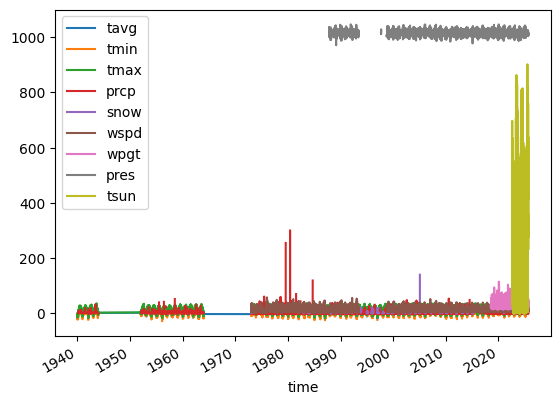

In [57]:
denni_ruzyne.plot();

Tam toho moc vidět není. Jedním z problémů je různá škála veličin. A také bychom si graf mohli trochu zvětšit.

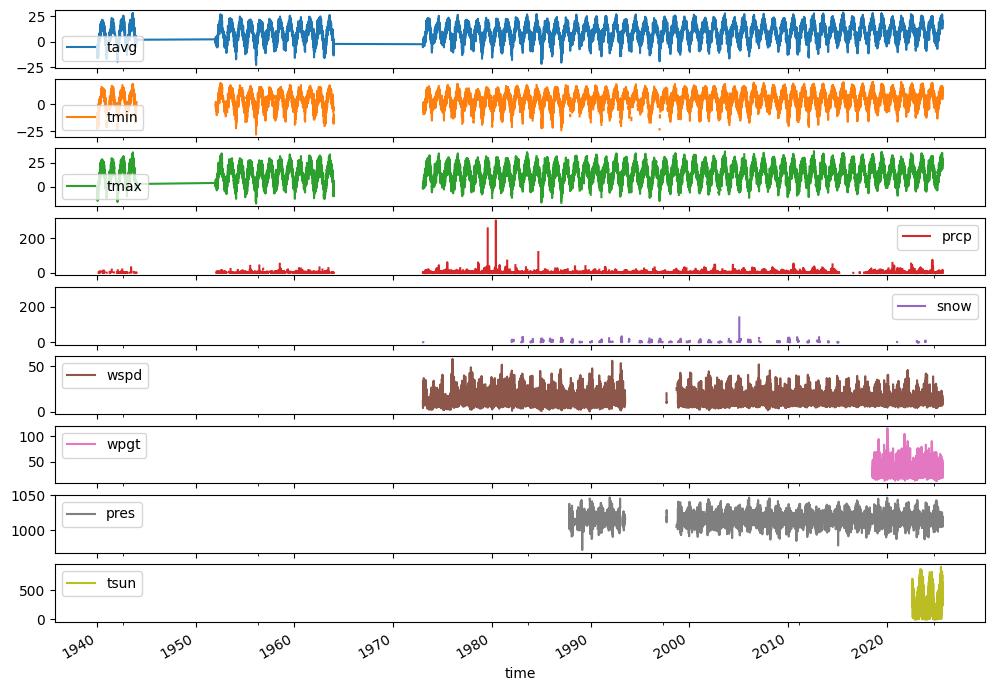

In [58]:
denni_ruzyne.plot(subplots=True, figsize=(12, 9));

Tohle už je docela užitečné, leccos na grafu vidět je. Výchozí čárový (`line`) graf je pro časové řady často vhodný.

Navíc už si graficky odpovídáme na to, proč máme tolik hodnot, kolik jich máme: Různé veličiny se v některých letech prostě vůbec neměřily, jiné se měřily jen občas.

Pomocí argumentu `layout` můžeme podgrafy uspořádat do více sloupců. Pokud navíc vybereme kratší časové období, dostaneme už celkem srozumitelný výsledek.

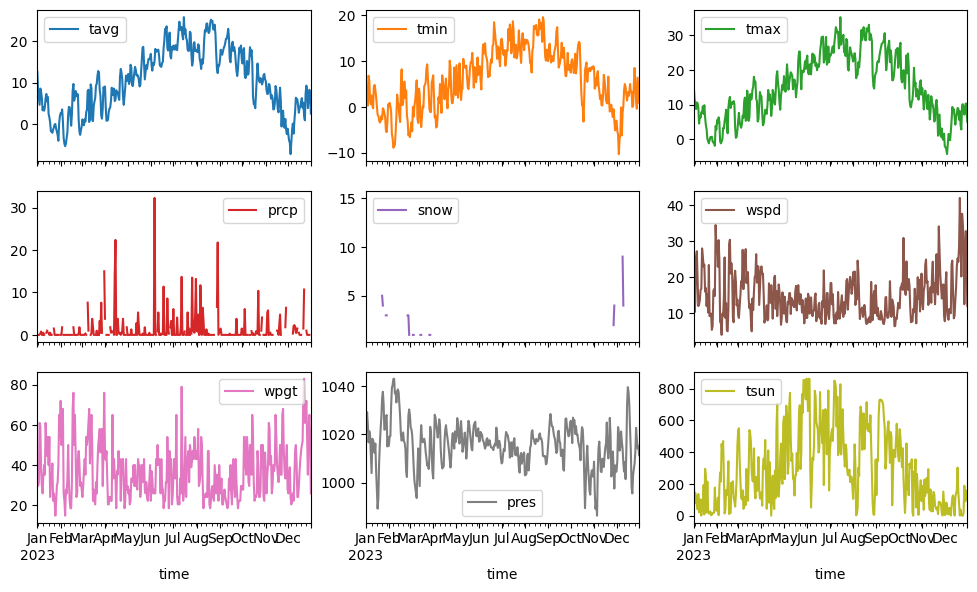

In [60]:
denni_ruzyne.loc["2023"].plot(
    subplots=True, layout=(4, 3), figsize=(12, 9)
);

I tady je ale dat poměrně hodně a na grafech vidíme spoustu rozptylu - hodnoty skáčou rychle nahoru / dolů. V takovém případě je na čase vzít si na pomoc statistiku!

## Trocha statistiky - opravdu jen základní

Není cílem tohoto kurzu (a ani v jeho možnostech) podrobně a rigorózně učit statistiku ("Statistika nuda je..."). Jednoduché základy, které zvládají i 🐼🐼🐼, spolu jistě zvládneme a přesvědčíme se, že jsou i užitečné ("...má však cenné údaje...").

Pokud se budeš chtít dozvědět víc, koukni třeba na https://www.poritz.net/jonathan/share/ldlos.pdf, nebo na http://greenteapress.com/thinkstats2/thinkstats2.pdf nebo třeba i na Bayesovskou statistiku http://www.greenteapress.com/thinkbayes/thinkbayes.pdf.

Metoda [`DataFrame.describe`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.describe.html#pandas.DataFrame.describe) je jednoduchou volbou pro získání základních statistik celé tabulky.

In [61]:
denni_ruzyne.describe()

,tavg,tmin,tmax,prcp,snow,wspd,wpgt,pres,tsun
count,23258.000000,20595.000000,22769.000000,14643.000000,1051.000000,16996.000000,2588.000000,11168.000000,1118.000000
mean,8.633915,4.478631,13.237187,1.609131,7.550904,14.196276,33.702125,1017.130632,276.325581
std,8.105865,7.136165,9.424716,5.329052,14.504778,6.967221,13.409534,8.598222,219.449714
min,-23.100000,-27.800000,-17.800000,0.000000,1.000000,0.200000,13.000000,971.100000,0.000000
25%,2.400000,-0.200000,5.700000,0.000000,2.000000,9.100000,24.100000,1011.900000,90.000000
50%,9.100000,5.000000,13.800000,0.000000,4.000000,12.700000,29.600000,1017.000000,230.500000
75%,15.200000,10.000000,20.900000,1.300000,10.000000,17.800000,40.800000,1022.400000,433.750000
max,28.600000,21.000000,37.400000,301.000000,296.000000,58.000000,115.000000,1046.600000,902.000000


Pro každý sloupec vidíme několik souhrnných (statistických údajů).
* `count` udává počet hodnot.
* `mean` je střední hodnota, vypočítaná jako aritmetický průměr. 
* `std` je směrodatná odchylka, která ukazuje rozptyl dat - jak moc můžeme očekávat, že se data v souboru budou lišit od střední hodnoty.
* `min` a `max` jsou nejmenší a největší hodnoty ve sloupci.
* Procenta označují kvantily, `25%` a `75%` je hodnota prvního a třetího "kvartilu". Pokud bychom sloupec seřadili podle podle velikosti, bude čtvrtina dat menší než hodnota prvního kvartilu a čtvrtina dat bude větší než hodnota třetího kvartilu. Konkrétně čtvrtina všech dní v našich datech měla minimální teplotu menší než -0.7 °C a čtvrtina dní zase měla maximální teplotu větší než 20.5 °C. 
* `50%` se označuje jako medián - polovina dat je menší než medián (a ta druhá polovina je samozřejmě zase větší než medián).

Za chvilku si ještě ukážeme, jak tyto hodnoty souvisi s distribuční funkcí a vše ti bude hned jasnější :)

`describe` můžeme samozřejmě použít i na nějakou podmožinu dat. Takto třeba vypadá statistika počasí v Ruzyni v lednu.

In [62]:
denni_ruzyne[denni_ruzyne.index.month == 1].describe()

,tavg,tmin,tmax,prcp,snow,wspd,wpgt,pres,tsun
count,1906.000000,1616.000000,1823.000000,1027.000000,305.000000,1462.000000,217.000000,953.000000,93.000000
mean,-1.457922,-4.038552,1.213275,0.858812,8.045902,16.667921,38.267281,1019.951207,93.913978
std,5.237619,5.653606,5.087210,1.641651,9.893405,9.490501,16.080667,11.225654,97.403091
min,-22.000000,-24.000000,-17.000000,0.000000,1.000000,0.800000,13.000000,977.600000,0.000000
25%,-4.300000,-7.200000,-1.900000,0.000000,3.000000,9.200000,24.100000,1012.400000,19.000000
50%,-0.700000,-3.000000,1.400000,0.000000,5.000000,14.700000,37.000000,1020.600000,61.000000
75%,2.000000,0.000000,4.500000,1.300000,12.000000,22.675000,50.000000,1028.000000,130.000000
max,12.600000,9.600000,16.000000,16.000000,140.000000,58.000000,115.000000,1046.500000,402.000000


### Statistické rozdělení

Pojďme zkusit pojmy kolem pravděpodobnosti, jako třeba rozdělovací funkce nebo hustota pravděpodobnosti, jejichž formální definice a vlastnosti lze najít v knihách (např. v těch uvedených výše) nebo na [wikipedii](https://cs.wikipedia.org/wiki/Distribu%C4%8Dn%C3%AD_funkce), objevovat a zkoumat spíš názorně a intuitivně.

Jedním ze základních a nesmírně užitečných nástrojů na vizualizaci souboru dat je [histogram](https://cs.wikipedia.org/wiki/Histogram). Zjednodušeně řečeno, histogram vytvoří chlívečky podle velikosti dat - do každého chlívečku patří data v nějakém intervalu od - do. Počet hodnot, které ze souboru dat spadnou do daného chlívečku, určuje velikost (výšku) chlívečku.

Histogram zobrazíme pomocí `.plot.hist()`

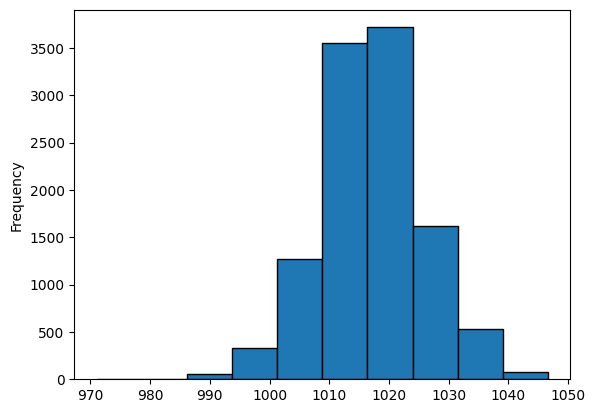

In [63]:
denni_ruzyne["pres"].plot.hist(edgecolor="black");

Histogram nám říká, že někde v rozmezí 1008 - 1023 je nejvíce hodnot (~7000). Okolní chlívečky mají už výrazně menší velikost, sotva poloviční. Na okrajích jsou jen nízké chlívečky, jakési ocasy.

Přemýšlej - kdybychom si vybrali náhodně jeden den. 
1. Z kterého (jednoho) z chlívečků v grafu bude nejčastěji ležet tlak? 
2. Jakých 5 chlívečků bys vybrala, abys měla opravdu hodně velkou šanci, že tlak ve vybraném dni bude v jednom z těchto chlívečků?

Pokud dokážeš na otázky odpovědět, tak už vlastně víš, že histogram udává *hustotu pravděpodobnosti* a že tahle hustota se dá sčítat, čímž se dostane *kumulovaná pravděpodobnost*, neboli také *distribuční funkce*.

Definice je vlastně docela jednoduchá (zdroj [wikipedia](https://cs.wikipedia.org/wiki/Distribu%C4%8Dn%C3%AD_funkce)): 

> Distribuční funkce, funkce rozdělení (pravděpodobnosti) nebo (spíše lidově) (zleva) kumulovaná pravděpodobnost (anglicky Cumulative Distribution Function, CDF) je funkce, která udává pravděpodobnost, že hodnota náhodné proměnné je menší než zadaná hodnota. 

Hustota pravděpodobnosti vyjadřuje, kolik "pravděpodobnosti" přibude na daném intervalu, neboli o kolik se změní distrubuční funkce. Matematicky je hustota pravděpodobnosti derivací distribuční funkce.

Poměrně důležitým parametrem u histogramu je počet chlívků. Když jich je málo, může zaniknout důležitá informace, moc chlívků může zase vnést velký šum. 

Pro naše data vypadá histogram s třiceti chlívky celkem rozumně.

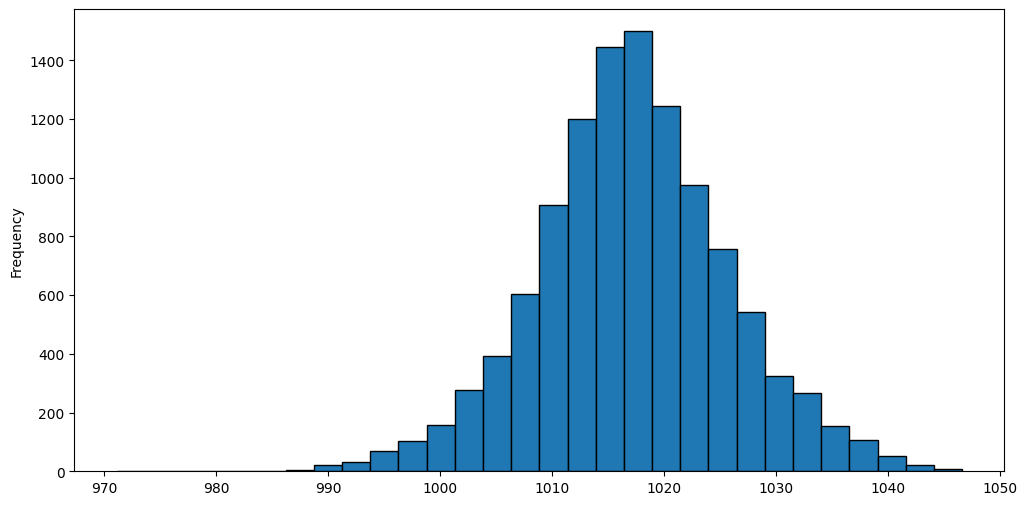

In [48]:
denni_ruzyne["pres"].plot.hist(bins=30, figsize=(12, 6), edgecolor="black");

Na vlastní nebezpečí můžete na tvoření histogramů použít [physt](https://github.com/janpipek/physt) Honzy Pipka. Přidává  pár zajímavých vlastností a často usnadní práci.

In [64]:
# physt možná nemáte nainstalovaný - stačí odkomentovat
!uv pip install physt

Using Python 3.13.5 environment at: C:\Users\janpi\Documents\code\pyladies-kurz\.venv
Resolved 14 packages in 432ms
Installed 6 packages in 94ms
 + hypothesis==6.140.2
 + markdown-it-py==4.0.0
 + mdurl==0.1.2
 + physt==0.9.0
 + rich==14.1.0
 + sortedcontainers==2.4.0


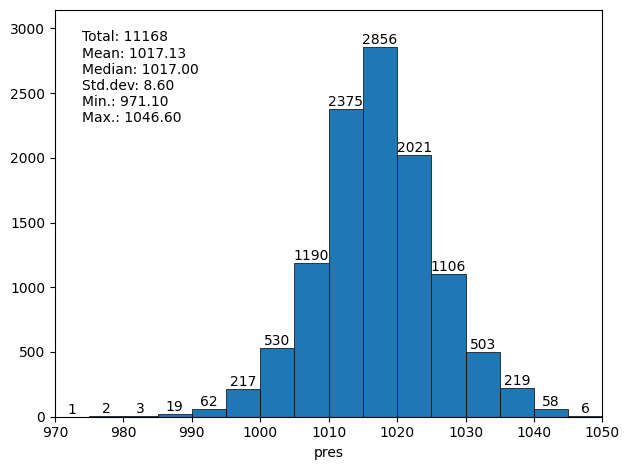

In [65]:
import physt

histogram = physt.h1(denni_ruzyne["pres"], "fixed_width", bin_width=5)
histogram.plot(edgecolor="black", show_values=True, show_stats=True);

Argument `cumulative=True` nám pak zobrazí postupný (kumulativní) součet velikosti chlívků. Použijeme ještě `density=True`, abychom zobrazili distribuční funkci. Takto nám graf říká, jaká je pravděpodobnost (hodnota na vertikální ose), že tlak bude menší než daná hodnota (na horizontální ose). 

V grafu jsou ještě přidané svislé čáry pro střední hodnotu (černá), medián (červená) a 25% a 75% kvantily (červené přerušované).

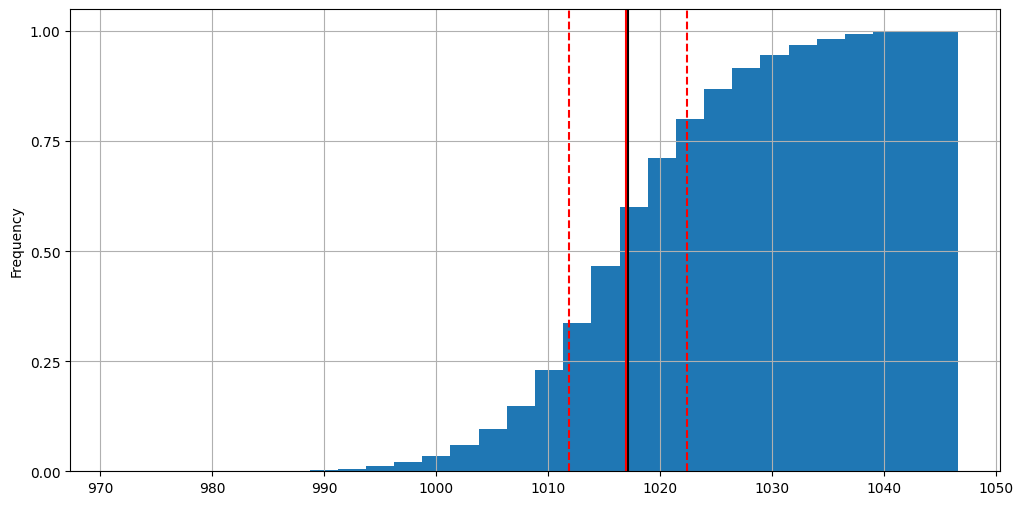

In [66]:
ax = denni_ruzyne["pres"].plot.hist(
    bins=30, figsize=(12, 6), cumulative=True, density=True, grid=True
)
ax.set_yticks(np.arange(0, 1.1, 0.25))
ax.axvline(denni_ruzyne["pres"].mean(), color="k")
ax.axvline(denni_ruzyne["pres"].median(), color="r")
ax.axvline(denni_ruzyne["pres"].quantile(0.25), color="r", ls="--")
ax.axvline(denni_ruzyne["pres"].quantile(0.75), color="r", ls="--")

Podívejme se, jak vypadají histogramy všech devíti veličin. 

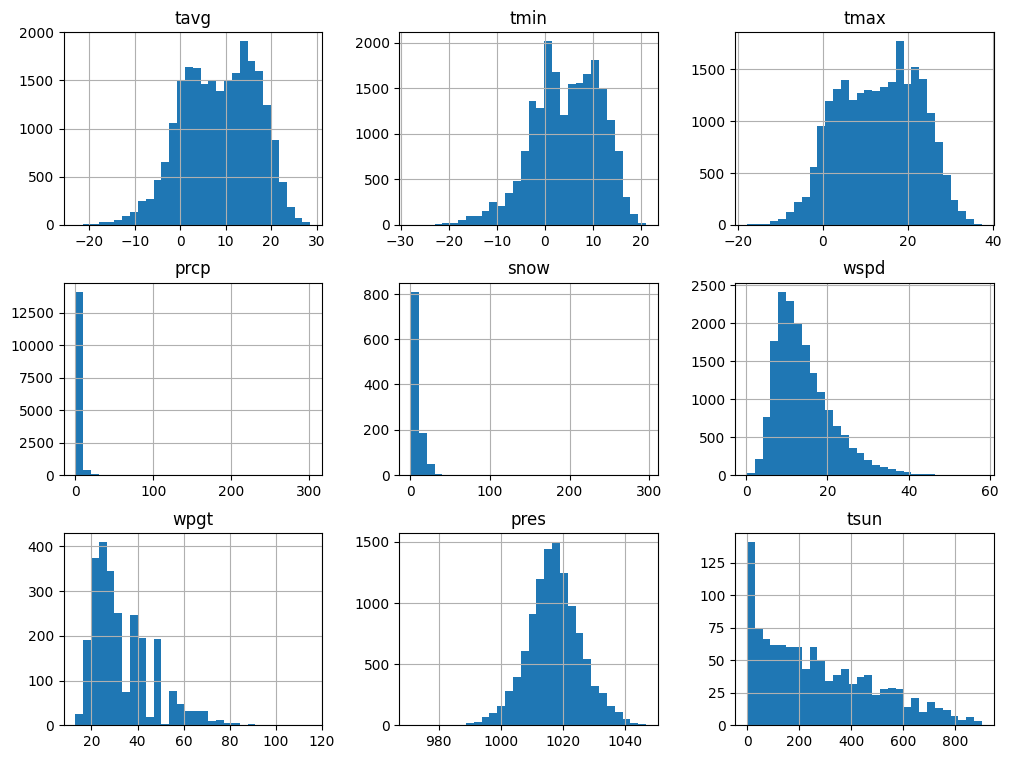

In [67]:
denni_ruzyne.hist(figsize=(12, 9), bins=30);

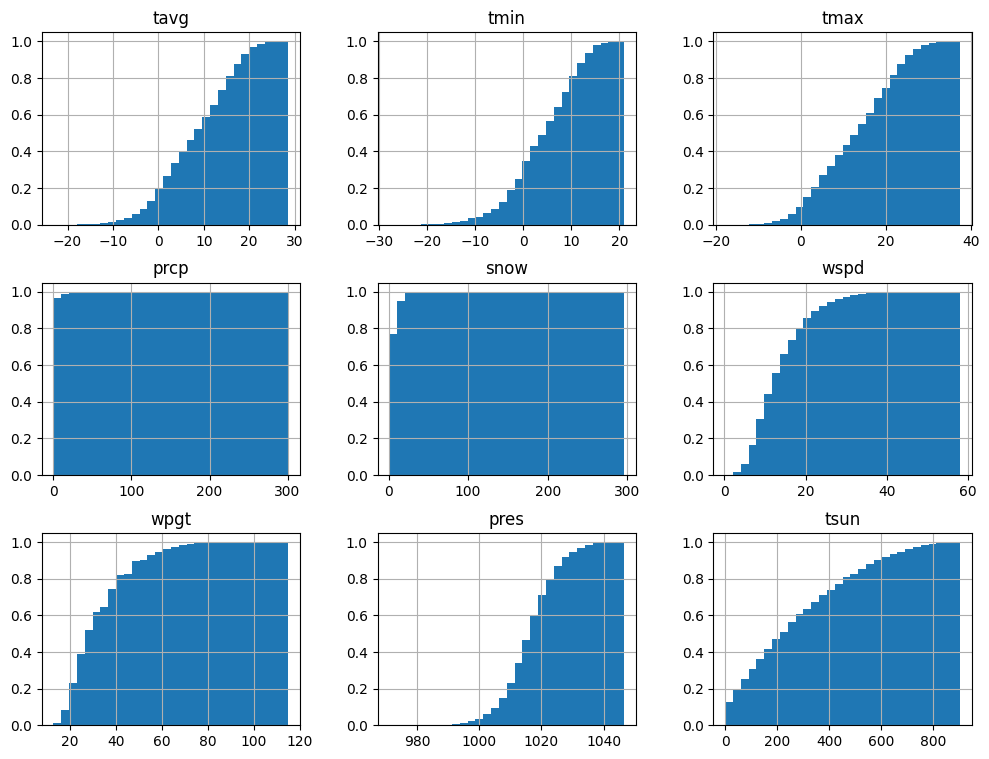

In [68]:
denni_ruzyne.hist(figsize=(12, 9), bins=30, cumulative=True, density=True);

Je poměrně zajímavé a příhodné, že dostáváme poměrně hezkou paletu různých typu rozdělovací funkce. Tlak vzduchu má přibližně **[normální (Gaussovo) rozdělení](https://cs.wikipedia.org/wiki/Norm%C3%A1ln%C3%AD_rozd%C4%9Blen%C3%AD)**. O tom jste možná slyšeli, protože se vyskutuje a používá poměrně často (někdy až příliš často). U teploty je zajímavé, že má tzv. **bi-modální rozdělení** - na histogramu jsou dvě maxima. U dalších veličin se můžeme zamyslet, která z [mnoha známých distribucí](https://en.wikipedia.org/wiki/Log-normal_distribution) by se na jejich popis více či méně hodila. Logaritmicko-normální na na rychlost větru? Nějaká exponenciální (nebo obecně gamma) distribuce výšky sněhu, úhrnu srážek a možná slunečního svitu? Toto ponechejme na nějaký podrobnější kurz statistiky, meteorologie či klimatologie :)

Různorodé distribuční funkce nám ale umožní ukázat některé vlastnosti střední hodnoty a mediánu. To jsou (společně s módy, tedy maximy hustoty pravděpodobnosti) ukazatele centrální tendence souboru dat. Medián a střední hodnota se poměrně často neliší a u "hezkých" (symetrických) distribucí, jako je normální rozdělení, jsou totožné. Lišit se budou zejména tehdy, když je distribuce sešikmená (angl. skewed) nebo pokud jsou v datech odlehlé hodnoty, spíše známé pod anglickým výrazem [outliers](https://en.wikipedia.org/wiki/Outlier).

Zabalíme do funkce vykreslovaní histogramu spolu se střední hodnotou a kvantily, které jsme použili již dříve. Poté použijeme velice užitečnou knihovnu [seaborn](https://seaborn.pydata.org) na vykreslení histogramů pro jednotlivé veličiny.

In [69]:
def hist_plot_with_extras(data, bins=30, cumulative=False, density=False, **kwargs):
    """Plot histogram with mean and quantiles"""
    ax = kwargs.pop("ax", plt.gca())
    ax.hist(data, bins=bins, cumulative=cumulative, density=density, **kwargs)
    ax.grid(True)
    if density:
        ax.set_yticks(np.arange(0, 1.1, 0.25))
    ax.axvline(data.mean(), color="k")
    ax.axvline(data.median(), color="r")
    ax.axvline(data.quantile(0.25), color="r", ls="--")
    ax.axvline(data.quantile(0.75), color="r", ls="--")
    return ax

Všimněte si použití `.melt()` - seaborn totiž očekává data v jednom sloupci, jednotlivé grafy pak tvoří na základě hodnoty jiného sloupce. Vytvořili jsme vlastně kategorickou proměnnou "value".

Teď můžeme použít [`FacetGrid`](https://seaborn.pydata.org/generated/seaborn.FacetGrid.html), který vytváří sadu grafů, rozdělených do mřížky podle nějaké vlastnosti dat (kategorie).

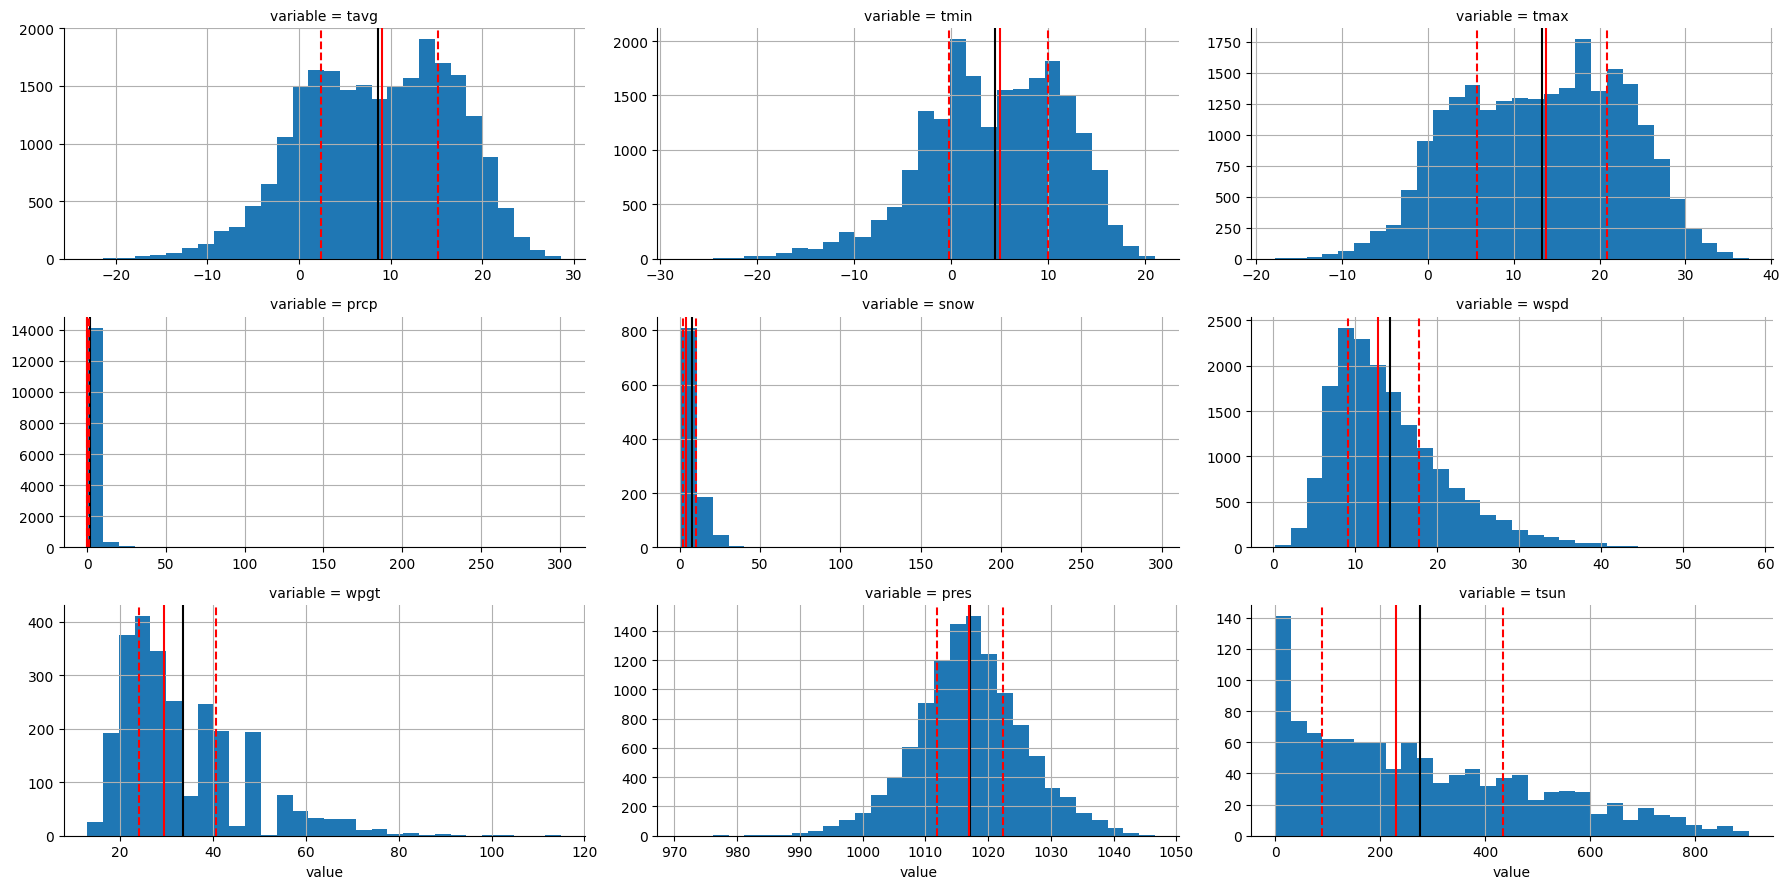

In [71]:
grid = sns.FacetGrid(
    denni_ruzyne.melt(),
    col="variable",
    col_wrap=3,
    sharey=False,
    sharex=False,
    aspect=2,
)
grid.map(hist_plot_with_extras, "value");

Kromě histogramu se velice často používá pro zobrazení distribuce tzv. [boxplot](https://cs.wikipedia.org/wiki/Boxplot). "Krabička" (obdélník) uprostřed vymezuje oblast mezi prvním a třetím kvartilem (Q1 a Q3), dělicí čára odpovídá mediánu, a "vousy" (anglicky whiskers) značí rozsah dat. Standardně je to poslední bod, který je menší / větší než 1,5násobek "inter-quartile range" IQR, `IQR = Q3 - Q1`. Tento rozsah se obvykle považuje za mez pro odlehlé hodnoty, které jsou pak v boxplotu vyznačeny jako symboly (kosočtverce v našem případě).

c:\Users\janpi\Documents\code\pyladies-kurz\.venv\Lib\site-packages\seaborn\axisgrid.py:718: UserWarning:

Using the boxplot function without specifying `order` is likely to produce an incorrect plot.



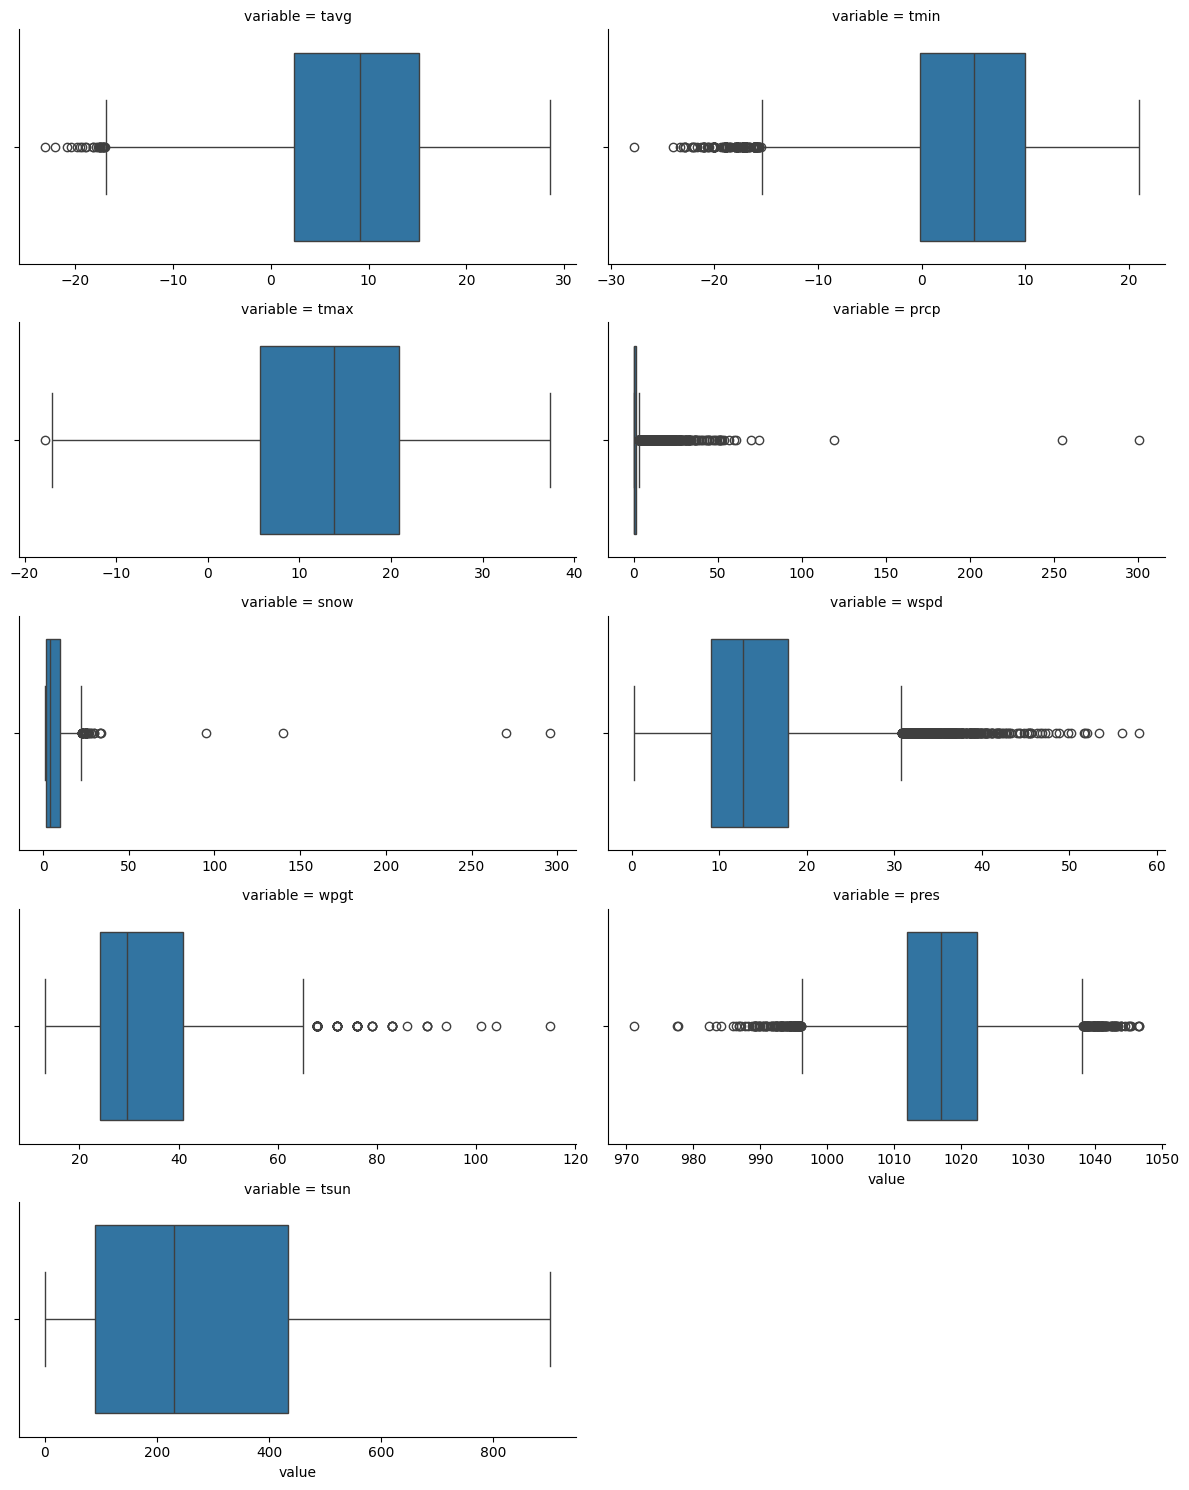

In [74]:
grid = sns.FacetGrid(
    denni_ruzyne.melt(),
    col="variable",
    col_wrap=2,
    sharey=False,
    sharex=False,
    aspect=2,
)
grid.map(sns.boxplot, "value");

Seaborn se často dá použít velice jednoduše, pokud zobrazujeme jednu veličinu, a někdy stráví i "wide-format" data. U našich dat můžeme takto porovnat průměrnou, minimální a maximální teplotu. Na pomoc si vezmeme [`catplot`](https://seaborn.pydata.org/generated/seaborn.catplot.html), který vytváří graf (nebo i sadu grafů) různých typů (boxplot nebo třeba violinplot) z dat obsahujících jednu či více kategorických proměnných.

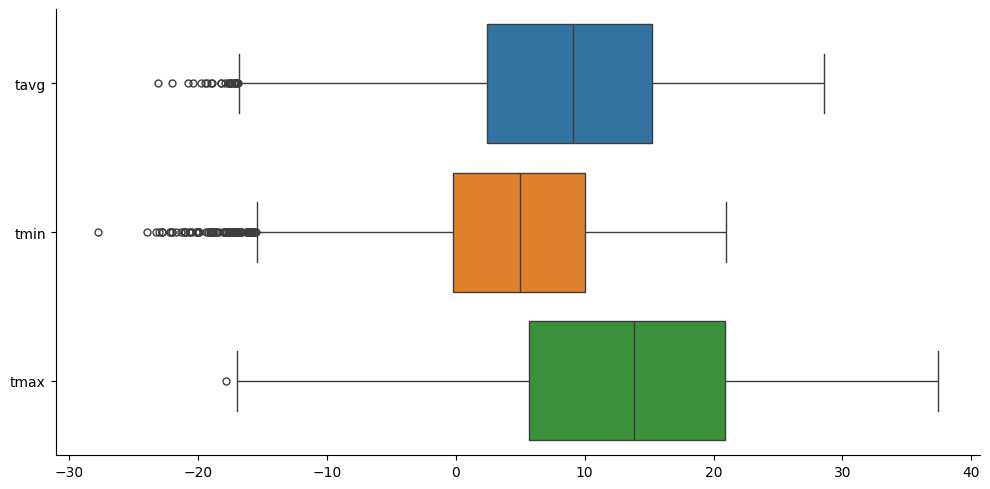

In [73]:
sns.catplot(
    data=denni_ruzyne[["tavg", "tmin", "tmax"]],
    orient="h",
    kind="box",
    aspect=2,
);

**Úkol**: Doplňte pomocné sloupce `season` a `significant_precipitation` (jistě uhádnete jakého pandas-typu budou :). První definuje roční období (jen jednoduše podle kalendářních měsíců), druhý označuje dny, kdy byly srážky vyšší než v **90 %** všech dní v našich datech (můžete zkusit i jiný limit).

1. Porovnejte numericky základní statistiky celého datasetu a podmnožiny, kdy výrazně pršelo nebo sněžilo. Zvyšují v průměru srážky teplotu? A co maximální nebo minimální? A jak je to se standardní odchylkou?
2. Použijte `sns.catplot` pro vizuální srovnání distribučních funkcí pro jednotlivá roční období a dny s málo / hodně srážkami.

In [ ]:
# odkomentuj a doplň
# season = denni_ruzyne.index.___.map({
#     1: "zima",
#     2: "zima",
#     3: "jaro",
#     ...
#  })

# significant_precipitation = denni_ruzyne["prcp"] > denni_ruzyne[___].quantile(___)

In [ ]:
# úkol - jednoduché srovnání statistik pomocí rozdílu

# (denni_ruzyne.loc[___]
#  .describe()
# ) - \
# denni_ruzyne.___()

In [ ]:
# úkol - vizuální srovnání statistik

# sns.catplot(
#     data=denni_ruzyne.assign(
#         significant_precipitation=___,
#         season=___,
#     ),
#     kind="box",
#     aspect=2,
#     hue=___,
#     y=___,
#     x=___,
# );

## Práce s časovou řadou

Pojďme trochu zkombinovat statistiku a práci s časovou řadou. Zajímalo by vás, jak moc byl který rok teplý či studený? Pomocí [`resample`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html#pandas.DataFrame.resample) můžeme změnit rozlišení dat na jiné období, např. jeden rok.

In [ ]:
rocni_ruzyne = denni_ruzyne.resample("1YE")

AttributeError: 'DatetimeIndexResampler' object has no attribute 'resample'

Co že jsme to vlastně vytvořili?

In [ ]:
rocni_ruzyne

Dostali jsme instanci třídy `DatetimeIndexResampler`. To zní logicky, ale kde jsou data? Ta zatím nejsou, protože jsme ještě pandám neřekli, jak vlastně mají ze všech těch denních údajů v rámci jednoho roku vytvořit ta roční data. Neboli, jak data *agregovat*.

Ze statistiky víme, že jedním z ukazatelů může být střední hodnota. Zkusíme vypočítat průměrnou "teplotu průměrnou" (není to překlep) a rovnou vykreslit.

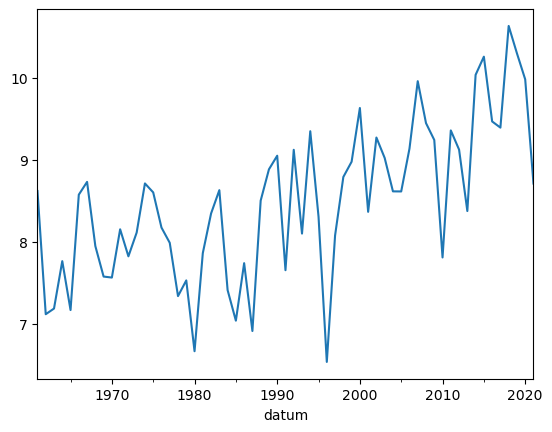

In [ ]:
rocni_ruzyne["tavg"].mean().plot();

Trochu podobnou operací jako resampling je rolování. To spočívá v plynulém posouvání "okna", které slouží pro (vážený) výběr dat a následné aplikaci agregační funkce (jako u `resample`). Pojďme pomocí [`rolling`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rolling.html#pandas.DataFrame.rolling) vytvořit podobný pohled na roční průměrnou teplotu. Rozdíl oproti `resample` je v tom, že dostaneme pro každý den jednu hodnotu, nikoli jen jednu hodnotu pro celý rok. A také už nemůžeme použít interval `"1Y"`, protože jeden (kalendářní) rok není dobře definovaný interval díky přestupným rokům.

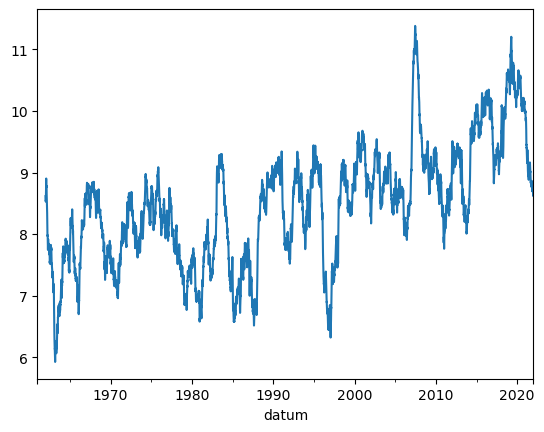

In [ ]:
rocni_ruzyne["tavg"].rolling("365.25D", min_periods=365).mean().plot();

Pro podrobnější přehled práce s časovými řadami se podívejta např. na https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html nebo třeba na hezký článek s podobnými daty https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/.

**Úkol:** Navrhněte vhodnou agregaci pro maximální teplotu (ne průměr) a vykreslete.

In [ ]:
# odkomentuj a doplň
# rocni_ruzyne[___].___().___();

**Úkol:** Převzorkujte údaje za rok 2018 po měsících. Jaký měsíc měl nejvíc srážek, tj. za jaký byl součet sloupce "úhrn srážek" nejvyšší?

In [ ]:
# doplňte nebo vyřešte po svém :)
# rocni_ruzyne.loc[___ == 2018, "prcp"].___(
#     "1M"
# ).___().___(ascending=False).index[___].___

## Časová data

Zatím jsme měli data s jednodenní hustotou a příliš jsme se nezabývali hodinami, časový zónami, přechodem mezi letním a zimním časem.

In [67]:
hodinove_ruzyne = pd.read_parquet("praha-meteostat.parquet").set_index("time")
hodinove_ruzyne

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
time,,,,,,,,,,,
1931-01-03 12:00:00,0.0,<NA>,<NA>,<NA>,<NA>,0.0,0.0,<NA>,1004.3,<NA>,<NA>
1931-01-03 18:00:00,1.1,<NA>,<NA>,<NA>,<NA>,0.0,0.0,<NA>,1002.8,<NA>,<NA>
1931-01-04 06:00:00,6.1,<NA>,<NA>,<NA>,<NA>,200.0,16.6,<NA>,1000.7,<NA>,<NA>
1931-01-04 12:00:00,11.1,<NA>,<NA>,<NA>,<NA>,160.0,3.6,<NA>,999.0,<NA>,<NA>
1931-01-04 18:00:00,6.1,<NA>,<NA>,<NA>,<NA>,270.0,33.5,<NA>,1001.8,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...
2025-08-31 19:00:00,19.4,9.3,52.0,0.0,<NA>,100.0,14.0,25.9,1012.3,0.0,1.0
2025-08-31 20:00:00,17.7,9.1,57.0,0.0,<NA>,120.0,14.0,29.6,1012.5,0.0,1.0
2025-08-31 21:00:00,17.1,9.0,59.0,0.0,<NA>,130.0,14.0,29.6,1012.3,0.0,1.0


In [68]:
hodinove_ruzyne.dtypes

temp    Float64
dwpt    Float64
rhum    Float64
prcp    Float64
snow    Float64
wdir    Float64
wspd    Float64
wpgt    Float64
pres    Float64
tsun    Float64
coco    Float64
dtype: object

In [76]:
hodinove_ruzyne = hodinove_ruzyne.assign(
    hour=hodinove_ruzyne.index.hour,
    day=hodinove_ruzyne.index.day,
    month=hodinove_ruzyne.index.month,
)

In [82]:
svit = hodinove_ruzyne[hodinove_ruzyne.month == 6][["day", "hour", "tsun"]].dropna()
svit

,day,hour,tsun
time,,,
2023-06-01 00:00:00,1,0,0.0
2023-06-01 01:00:00,1,1,0.0
2023-06-01 02:00:00,1,2,0.0
2023-06-01 03:00:00,1,3,0.0
2023-06-01 04:00:00,1,4,20.0
...,...,...,...
2025-06-30 19:00:00,30,19,38.0
2025-06-30 20:00:00,30,20,12.0
2025-06-30 21:00:00,30,21,0.0
